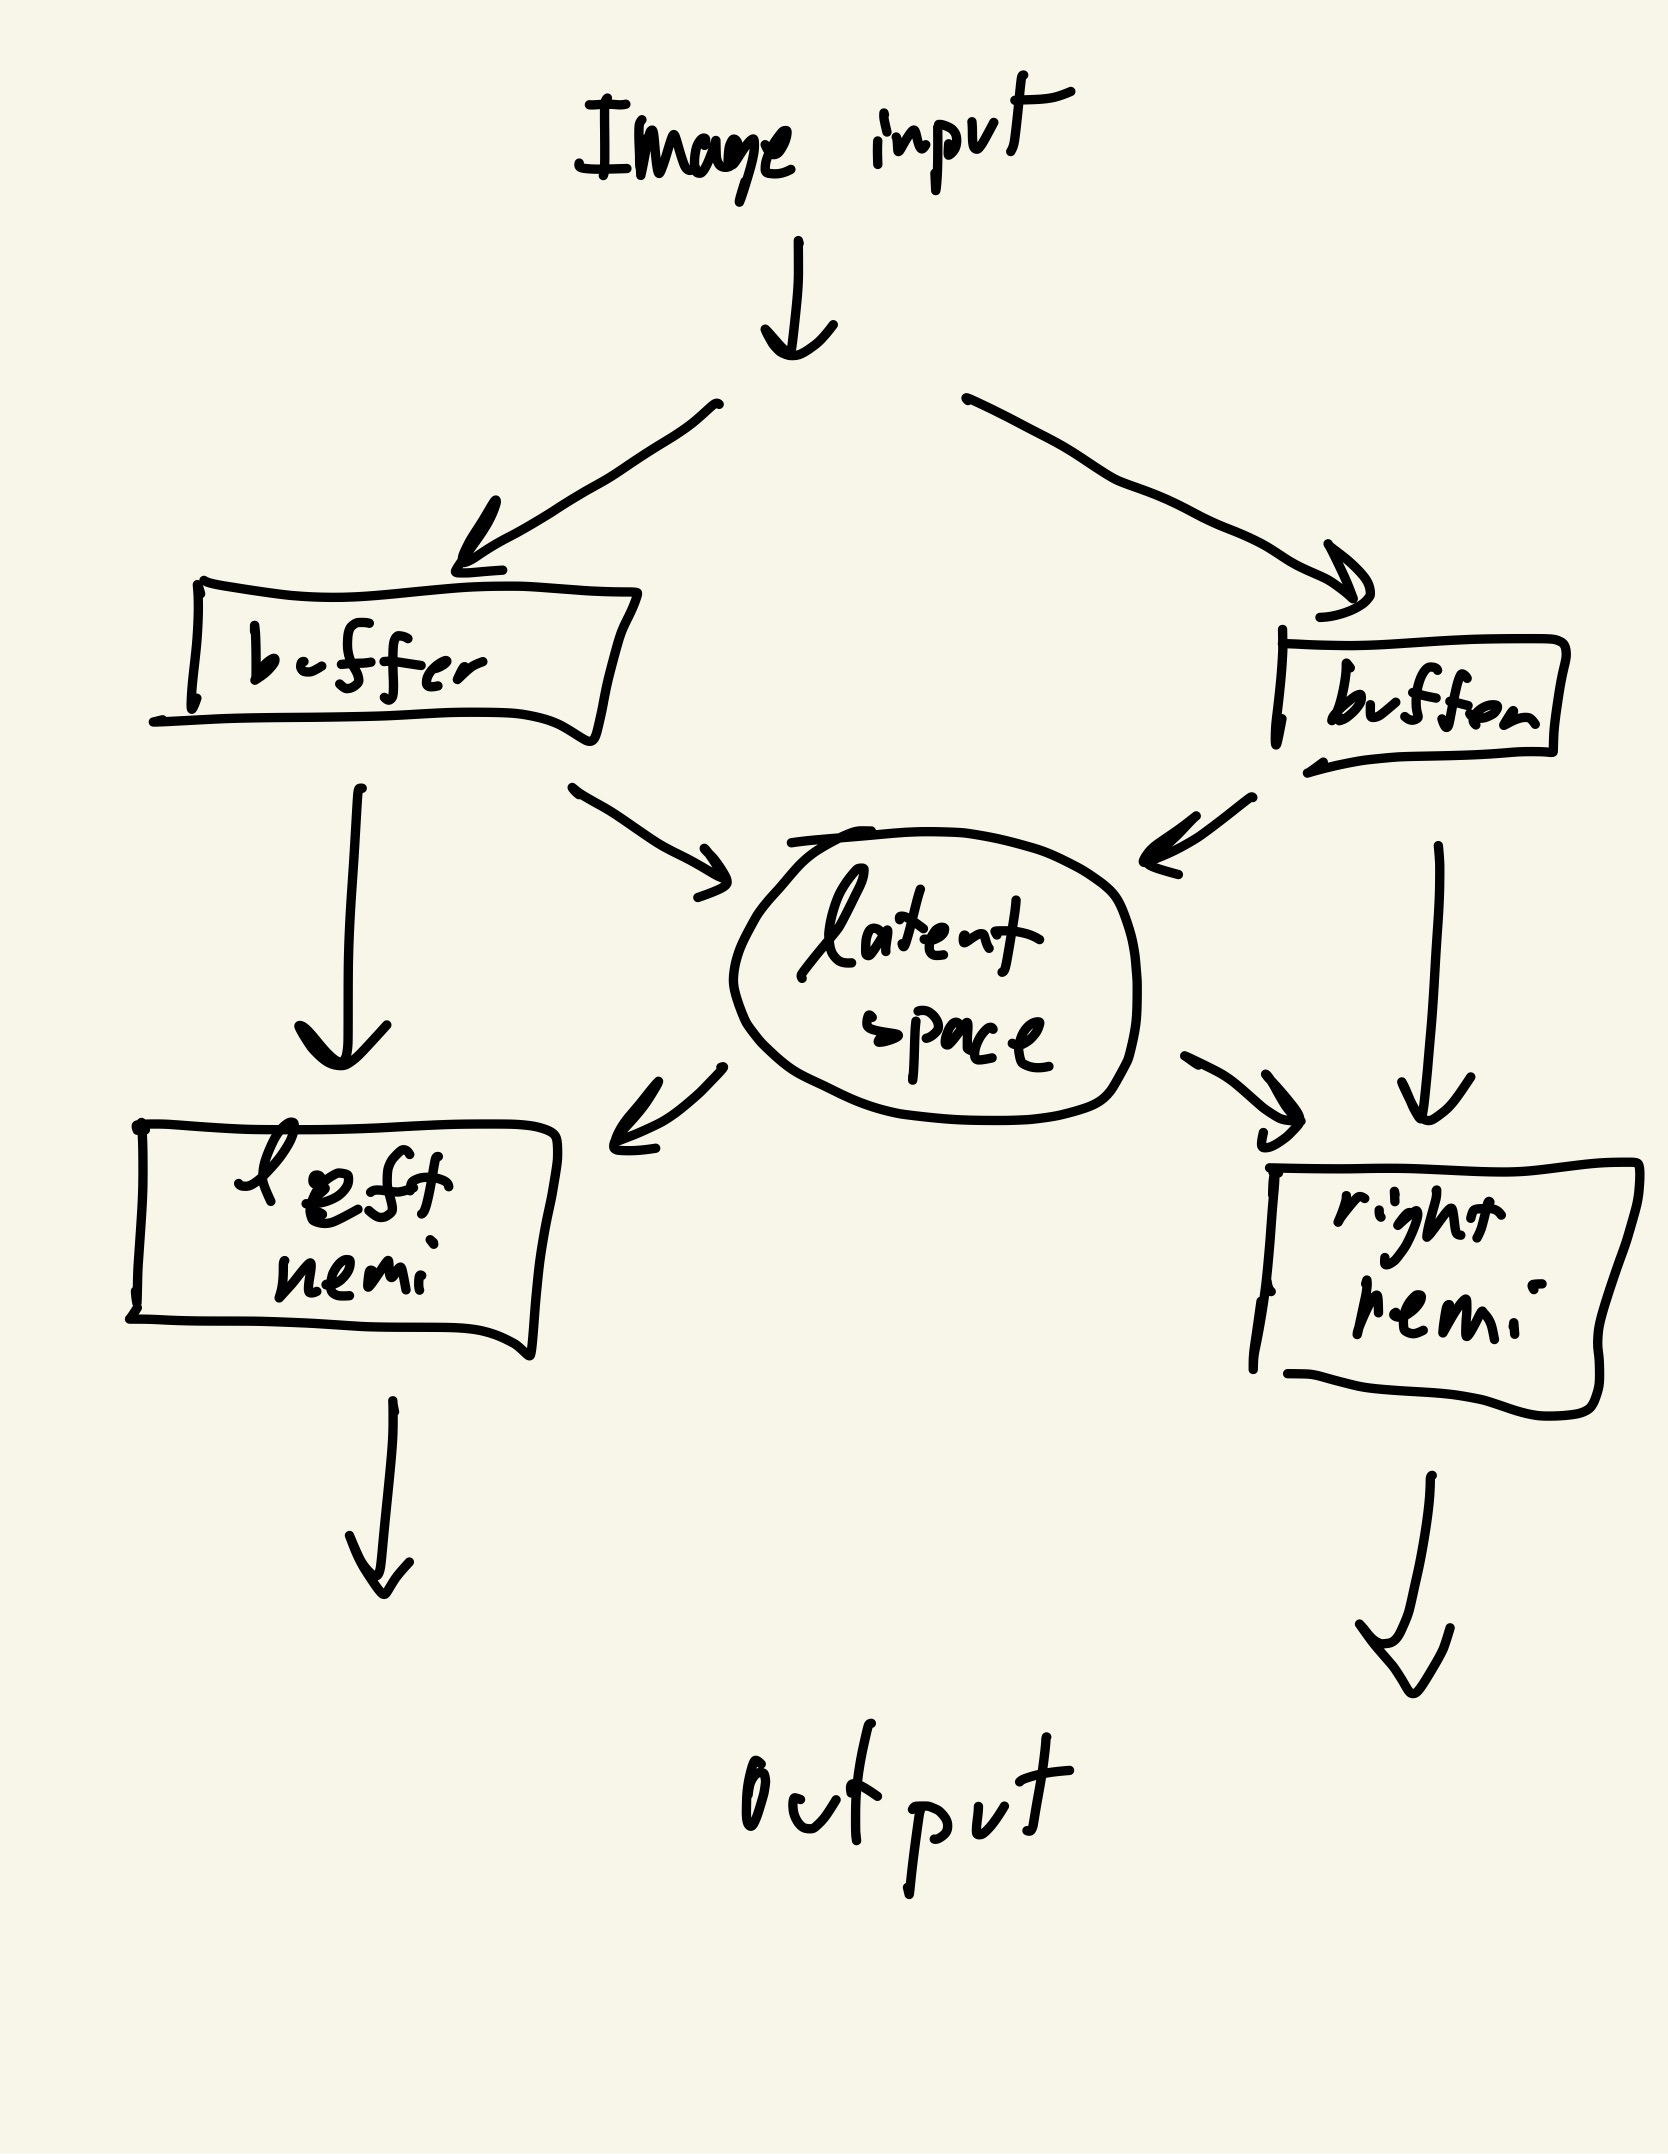

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(train_set, test_set), dataset_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [3]:
def preprocess(img, label):
    img = tf.image.resize(img, (150, 150))
    img = img / 255.0
    return img, label

train_set = train_set.map(preprocess).batch(33).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_set = test_set.map(preprocess).batch(32).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [5]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout

input_layer = Input(shape=(150, 150, 3))
flatten_layer = Flatten()(input_layer)

# Left Buffer
left_buffer_input = Dense(512, activation='relu')(flatten_layer)
left_buffer_mid = Dense(1024, activation='relu')(left_buffer_input)
left_buffer_out = Dense(512, activation='relu')(left_buffer_mid)

# Right Buffer
right_buffer_input = Dense(512, activation='relu')(flatten_layer)
right_buffer_mid = Dense(1024, activation='relu')(right_buffer_input)
right_buffer_out = Dense(512, activation='relu')(right_buffer_mid)

# Corpus Callosum Equivalence: Latent Space
latent_dim = 100
left_to_latent = Dense(latent_dim, activation='relu')(left_buffer_out)
right_to_latent = Dense(latent_dim, activation='relu')(right_buffer_out)

latent_rep = Concatenate()([left_to_latent, right_to_latent])

latent_to_left = Dense(512, activation='relu')(latent_rep)
latent_to_right = Dense(512, activation='relu')(latent_rep)

# Right Hemi
right_hemi_input = Concatenate()([latent_to_right, right_buffer_out])
right_hemi_input = Dropout(0.5)(right_hemi_input)
right_hemi_mid = Dense(1024, activation='relu')(right_hemi_input)
right_hemi_mid = Dense(512, activation='relu')(right_hemi_mid)
right_hemi_mid = Dense(256, activation='relu')(right_hemi_mid)
right_hemi_mid = Dense(64, activation='relu')(right_hemi_mid)
right_hemi_out = Dense(2, activation='softmax', name='right_out')(right_hemi_mid)

# Left Hemi
left_hemi_input = Concatenate()([latent_to_left, left_buffer_out])
left_hemi_input = Dropout(0.5)(left_hemi_input)
left_hemi_mid = Dense(1024, activation='relu')(left_hemi_input)
left_hemi_mid = Dense(512, activation='relu')(left_hemi_mid)
left_hemi_mid = Dense(256, activation='relu')(left_hemi_mid)
left_hemi_mid = Dense(64, activation='relu')(left_hemi_mid)
left_hemi_out = Dense(2, activation='softmax', name='left_out')(left_hemi_mid)

model = Model(inputs=input_layer, outputs=[left_hemi_out, right_hemi_out])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 flatten_2 (Flatten)            (None, 67500)        0           ['input_3[0][0]']                
                                                                                                  
 dense_36 (Dense)               (None, 512)          34560512    ['flatten_2[0][0]']              
                                                                                                  
 dense_39 (Dense)               (None, 512)          34560512    ['flatten_2[0][0]']        

In [6]:
model.fit(train_set, epochs=3, verbose=1, validation_data=test_set)

Epoch 1/3
564/564 [==============================] - 27s 21ms/step - loss: 1.5805 - left_out_loss: 0.7794 - right_out_loss: 0.8010 - left_out_accuracy: 0.5097 - right_out_accuracy: 0.5113 - val_loss: 1.3842 - val_left_out_loss: 0.6914 - val_right_out_loss: 0.6928 - val_left_out_accuracy: 0.5123 - val_right_out_accuracy: 0.5114
Epoch 2/3
564/564 [==============================] - 14s 20ms/step - loss: 1.3875 - left_out_loss: 0.6936 - right_out_loss: 0.6939 - left_out_accuracy: 0.5085 - right_out_accuracy: 0.4982 - val_loss: 1.3857 - val_left_out_loss: 0.6922 - val_right_out_loss: 0.6935 - val_left_out_accuracy: 0.5196 - val_right_out_accuracy: 0.4899
Epoch 3/3
564/564 [==============================] - 14s 20ms/step - loss: 1.3862 - left_out_loss: 0.6930 - right_out_loss: 0.6932 - left_out_accuracy: 0.5039 - right_out_accuracy: 0.5016 - val_loss: 1.3863 - val_left_out_loss: 0.6931 - val_right_out_loss: 0.6932 - val_left_out_accuracy: 0.5099 - val_right_out_accuracy: 0.4901
